In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
# !pip install graphviz

In [3]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dots(root, format='svg', rankdir='LR'):
    """
    format: svg
    rankdir: LR(left to right) | TB
    """
    # assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    for n in nodes:
        dot.node(name=str(id(n)), label="{%s | data: %.4f | grad: %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
class Value:

    def __init__(self, data, _child=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_child)
        self._op = _op
        self.label = label
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __sub__(self, other):
        return self + (-other)
    
    def __neg__(self):
        return self * (-1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only for int/float now"
        out = Value(self.data ** other, (self, ), f"pow({other})")

        def _backward():
            self.grad = other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):  # for other * Value instance
        return self * other
    
    def __truediv__(self, other):
        return self * other**(-1)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad 
        
        out._backward = _backward
        
        return out 
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

In [5]:
a = Value(3.0, label='a')
b = Value(-2.0, label='b')
# c = Value(5.0, label='c')

# e = a * b; e.label = 'e'
# d = e + c; d.label = 'd'
# f = Value(-10.0, label='f')
# l = d * f; l.label = 'l'
# O = l.tanh(); O.label = 'O'
a / b, a - b, 

(Value(data=-1.5), Value(data=5.0))

In [6]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); o.label = 'o'
e = (2 * n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()

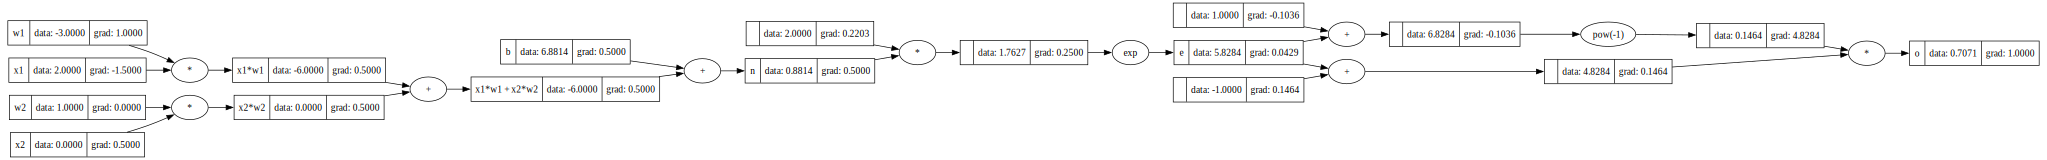

In [7]:
draw_dots(o)

In [8]:
class Neuron:
    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):  # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs
    
    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps =  neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, n_in, n_outs):
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [9]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n, n(x)

(<__main__.MLP at 0x136ad3810>, [Value(data=0.5867504657027868)])

In [10]:
len(n.parameters()), n.parameters()[:10]

(41,
 [Value(data=0.3586365270391829),
  Value(data=0.20525116831776713),
  Value(data=-0.04921142598833739),
  Value(data=0.686131514213886),
  Value(data=0.021980599059358674),
  Value(data=-0.6442811140729408),
  Value(data=0.8582233367004211),
  Value(data=-0.6946208910268121),
  Value(data=0.010612412133640614),
  Value(data=0.47430119201616994)])

In [11]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [12]:
ypred = [n(x) for x in xs]
# loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print(ypred)
for ygt, yout in zip(ys, ypred):
    print(ygt, yout)

[[Value(data=0.5867504657027868)], [Value(data=0.5608753257705245)], [Value(data=0.6339236788726605)], [Value(data=0.5453782051836257)]]
1.0 [Value(data=0.5867504657027868)]
-1.0 [Value(data=0.5608753257705245)]
-1.0 [Value(data=0.6339236788726605)]
1.0 [Value(data=0.5453782051836257)]


In [13]:
for i in range(10):
    ypred = [n(x) for x in xs]
    loss = sum((yout[0] - ygt)**2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.01 * p.grad
    print(i, loss.data)

0 5.483494524898935
1 5.122239857678013
2 4.714535111984317
3 4.267038976623003
4 3.7952119322258784
5 3.3217786351028664
6 2.8711486095972476
7 2.462557745843619
8 2.1061536639599114
9 1.803462607140712
